<a href="https://colab.research.google.com/github/ferit-osirv/osirv-lab-5-PatriciaA2/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ferit-osirv/lab5/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.png" alt="Open In Colab"/></a>

# Lab 5 - Image Convolution

**This command must be run before starting to do each lab.**

In [ ]:
!rm -rf clone && git clone https://github.com/ferit-osirv/lab5 clone && cp -a clone/. .

Cloning into 'clone'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 28 (delta 3), reused 17 (delta 3), pack-reused 11 (from 1)
Receiving objects: 100% (28/28), 601.71 KiB | 7.25 MiB/s, done.
Resolving deltas: 100% (4/4), done.


## Introduction

![](images/conv.png)

Generally, convolution is a mathematical operation between two functions. In the context of this assignment, however, we will focus on discrete 2D convolution between two square images, as that is most relevant for image processing. Convolution is denoted as $I(A) \star k(B)$ where $I(A)$ is an image $I(A) \in \mathbb{R}^{W \times H}$ and $k(B)$ is a matrix $k(B) \in \mathbb{R}^{a \times b}$ indexed by locations $B \in \mathbb{N}^2$ called the **convolutional kernel**. At pixel $(x, y)$, the convolution operation is defined as:

\begin{equation}
(I \star k)(x, y) = \sum_{i=-a}^{a} \sum_{j=-b}^{b} I[x + i, y + j] k[i, j]
\end{equation}

Explained differently, the resulting image is produced by sliding the kernel over the input image pixel by pixel. At each pixel location, values where the kernel and the image overlap are multiplied, and all of the products are summed together to form the corresponding pixel's value in the output image.

![](images/no_padding_no_strides.gif)

While mathematically a simple operation, convolution is exceedingly powerful and can produce almost endless transformations of an image. It's most commonly used for filtering --- a convolution can elegantly find patterns in the image and increase their intensity. One such example is the convolution with a kernel called the Prewitt operator:

\begin{equation}
I_y(A) = I(A) \star \begin{bmatrix}
-1 & 0 & 1\\
-1 & 0 & 1\\
-1 & 0 & 1\\
\end{bmatrix}
\end{equation}

When convolved with this kernel, the resulting image has high-intensity pixels in regions where vertical edges are present, and low intensity everywhere else. This can be seen in the following image:

![](images/prewitt-example.png)

Vertical edges necessarily have to have a large jump in values going from left to right or right to left. Otherwise, there would be no perceptible edge. This kernel takes advantage of that fact to accentuate parts of the image where there is such a jump. It does this by replacing each pixel with the difference between the pixels on its left and its right.

This process happens as follows. For each pixel of the input image, the kernel is placed such that it is centered on that pixel. This means that the values of the pixel as well as its neighbors above and below are all multiplied by zero. The neighbors on the left are multiplied by -1, and the ones on the right are multiplied by 1. Summed together, the result represents the sum of the values on the right of the pixel, minus the sum of the values on the left.

To illustrate this, let us consider $1 \times 3$ region of the image where no vertical edges are present:

\begin{equation}
\begin{bmatrix}
128 & 130 & 136\\
\end{bmatrix}
\star
\begin{bmatrix}
-1 & 0 & 1\\
-1 & 0 & 1\\
-1 & 0 & 1\\
\end{bmatrix}
=
\sum_{i,j}
\begin{bmatrix}
-1 \times 0 + 0 \times 128 + 1 \times 130\\
-1 \times 128 + 0 \times 130 + 1 \times 136\\
-1 \times 130 + 0 \times 136 + 1 \times 0\\
\end{bmatrix}
= 8
\end{equation}

This section of the image does not contain a vertical edge, so the convolution result is a relatively low value. In a standard image with values in $[0, 255)$, 8 would appear almost completely black.

However, consider some section of the image where a vertical edge is indeed present:

\begin{equation}
\begin{bmatrix}
63 & 66 & 132\\
\end{bmatrix}
\star
\begin{bmatrix}
-1 & 0 & 1\\
-1 & 0 & 1\\
-1 & 0 & 1\\
\end{bmatrix}
=
\sum_{i,j}
\begin{bmatrix}
-1 \times 0 + 0 \times 64 + 1 \times 66\\
-1 \times 64 + 0 \times 66 + 1 \times 132\\
-1 \times 66 + 0 \times 132 + 1 \times 0\\
\end{bmatrix}
= 68
\end{equation}

The value is now much larger due to the difference between the left and right sides of the image. This example demonstrates how a relatively simple kernel can capture complex features of an image.

Beyond edge detection, there are many commonly used convolution kernels to perform tasks such as blurring, sharpening, or denoising images. A convolutional neural network can leverage the power of the convolution by stringing together sequences of intricate kernels to match complex patterns in the image.

### Resources

- https://en.wikipedia.org/wiki/Kernel_(image_processing)
- https://vincmazet.github.io/bip/filtering/convolution.html
- https://arxiv.org/pdf/1603.07285.pdf

> ### Assignment 1: Implementing Convolution
>
> We will first implement a convolution operation from scratch. Convert the following equation into code:
>
> \begin{equation}
> (I \star k)(x, y) = \sum_{i=1}^{a} \sum_{j=1}^{b} I[x + i, y + j] k[i, j].
> \end{equation}
>
> This equation defines the convolution value for a single pixel $(x, y)$, where $I$ is the image and $k$ is a kernel of size $a \times b$. You will need to perform this operation for each pixel. Complete `convolve_py` by returning a convolved image.
>
> **Finish the code blocks below at the TODO comments. You do not need to change the rest of the code, or code blocks that do not have TODO comments.**

In [9]:
def convolve_py(img, kernel):
  '''
  Convolves an image with a kernel.
  Uses pure Python (no Numpy).

  Args:
    img: 2D numpy array of the image (grayscale, e.g. (128,128))
    kernel: 2D numpy array of the kernel
  '''
  # Get the dimensions of the image and kernel
  img_height, img_width = img.shape
  kernel_height, kernel_width = kernel.shape

  conv_result = np.zeros(img.shape)
  img = np.pad(img, (1, 1), 'constant', constant_values=(0, 0))

  for x in range(img_width):
    for y in range(img_height):
      # TODO: compute pixel (x, y) using equation above
      # Note: If the kernel goes outside the boundary of the image, assume that the values outside the image are zero.
      # Note: In mathematical notation, matrix indices start at 1. In Python, matrix indices start at 0.
      # Note: The `img` pixel (x, y) is `img[y, x]`.
      pixel_sum = 0
      for i in range(kernel_height):
        for j in range(kernel_width):
          pixel_sum += img[y + i, x + j] * kernel[i,j]
      conv_result[y,x] = pixel_sum
  return conv_result

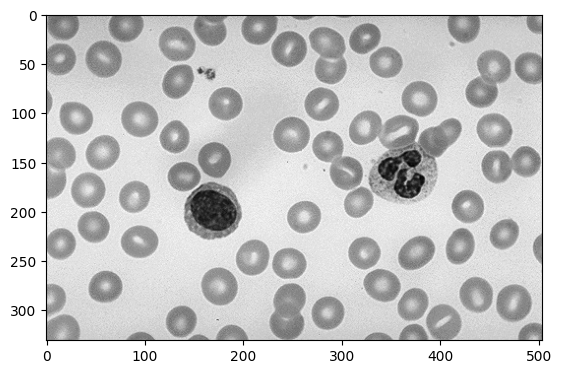

-667.0 678.0


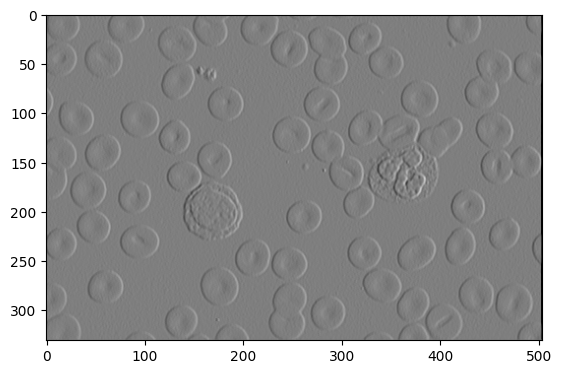

In [10]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

img = cv.imread('images/cells.jpg', cv.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.show()
kernel = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])

img_out = convolve_py(img, kernel)
print(img_out.min(), img_out.max())
plt.imshow(img_out, cmap='gray')

> ### Assignment 2: Speeding up convolution with numpy
>
> This time, implement the equation above using Numpy functions on matrices to calculate the convolved pixel value as `np.sum(window * kernel)`.

In [ ]:
def convolve_np(img, kernel):
  '''
  Convolves an image with a kernel.
  Uses Numpy.

  Args:
    img: 2D numpy array of the image (grayscale)
    kernel: 2D numpy array of the kernel
  '''
  # Get the dimensions of the image and kernel
  img_height, img_width = img.shape
  kernel_height, kernel_width = kernel.shape

  conv_result = np.zeros(img.shape)
  img = np.pad(img, ((1, 1), (1, 1)), 'constant', constant_values=0)

  for x in range(img_width):
    for y in range(img_height):
      window = img[y:y+kernel_height, x:x+kernel_width]
      conv_result[y, x] = np.sum(window * kernel)

  return conv_result

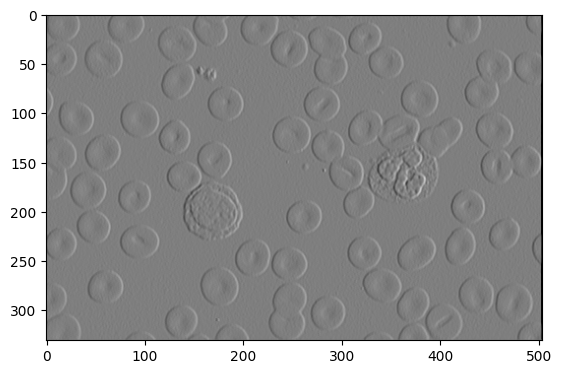

In [ ]:
img = cv.imread('images/cells.jpg', cv.IMREAD_GRAYSCALE)
img_out = convolve_np(img, kernel)
plt.imshow(img_out, cmap='gray')

Let us check which implementation is faster using the timeit library.

In [13]:
import timeit

# Time the pure Python version
time_py = timeit.timeit('convolve_py(img, kernel)', number=5, globals=globals())
print('Pure Python: {:.5f}s'.format(time_py))

# Time the dot product version (should be a few seconds faster)
time_np = timeit.timeit('convolve_np(img, kernel)', number=5, globals=globals())
print('NumPy: {:.5f}s'.format(time_np))

Pure Python: 7.25527s
NumPy: 6.30950s


## Understanding kernels

Different convolutional kernels can achieve different effects such as:

 - edge detection
 - image engancement (e.g. sharpening)
 - blurring
 - denoising
 - feature detection

You can see various examples of kernels here:

 - https://en.wikipedia.org/wiki/Kernel_(image_processing)
 - https://setosa.io/ev/image-kernels/

> ### Assignment 3: Edge Detection
>
> Find a good convolutional kernel to perform edge detection on the cell image.
>
> Use the cv.filter2D function with your chosen kernel and display the resulting image.

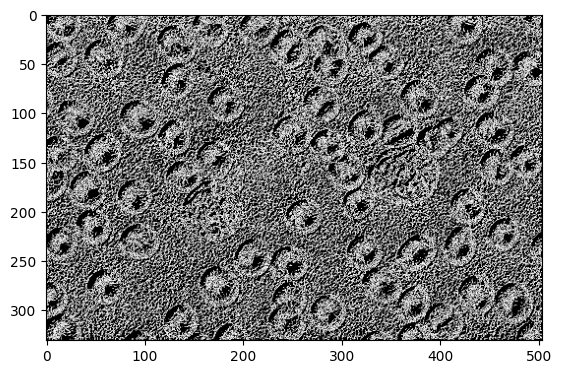

In [16]:
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])


img_sobel_x = cv.filter2D(img, -1, sobel_x)
img_sobel_y = cv.filter2D(img, -1, sobel_y)

# Combine the results (e.g., using magnitude)
img_sobel = np.sqrt(img_sobel_x**2 + img_sobel_y**2)

plt.imshow(img_sobel, cmap='gray')
plt.show()

> ### Assignment 4: Edge Detection with Blur
>
> Find a convolutional kernel to blur the image and display the blurred result.
>
> Then, apply the edge detection kernel (from Assignment 3) on the blurred image and display the result.

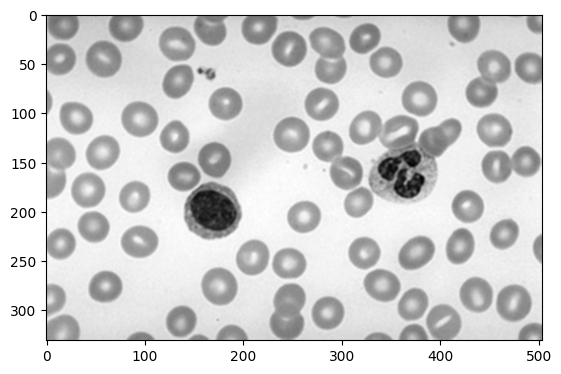

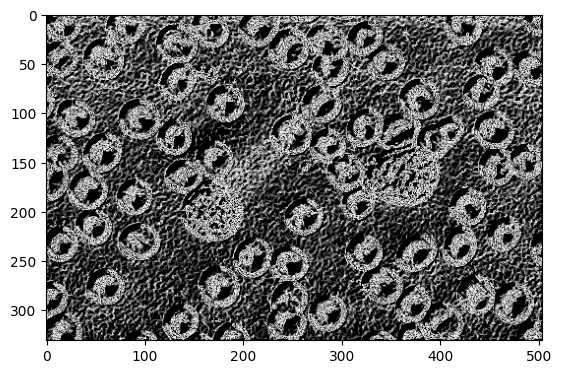

In [18]:
blur_kernel = np.array([[1/9, 1/9, 1/9],
                        [1/9, 1/9, 1/9],
                        [1/9, 1/9, 1/9]])

# Apply blurring
blurred_img = cv.filter2D(img, -1, blur_kernel)
plt.imshow(blurred_img, cmap='gray')
plt.show()

# Apply edge detection on the blurred image
blurred_sobel_x = cv.filter2D(blurred_img, -1, sobel_x)
blurred_sobel_y = cv.filter2D(blurred_img, -1, sobel_y)
blurred_sobel = np.sqrt(blurred_sobel_x**2 + blurred_sobel_y**2)

plt.imshow(blurred_sobel, cmap='gray')
plt.show()

> ### Assignment 4: Using Large Kernels
>
> The next code block constructs an image. You job is to recreate the image using a convolution.
>
> Hint: https://vincmazet.github.io/bip/filtering/convolution.html

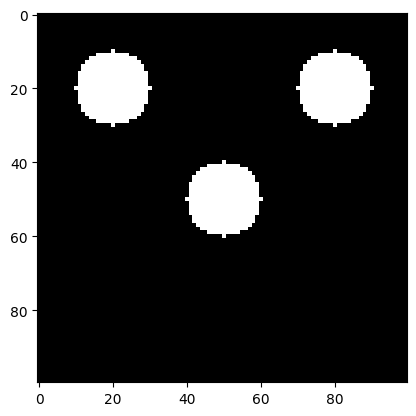

In [19]:
img_out = np.zeros((100, 100))
circle_origins = [(50, 50), (20, 20), (80, 20)]
circle_radius = 10

for (x, y) in circle_origins:
  img_out = cv.circle(img_out, (x, y), circle_radius, 1, -1)

plt.imshow(img_out, cmap='gray')
plt.show()

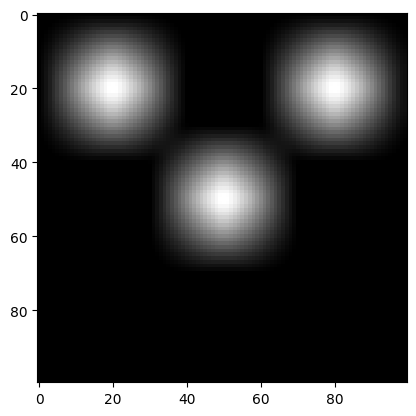

In [20]:
kernel = np.zeros((circle_radius * 2 + 1, circle_radius * 2 + 1))
kernel = cv.circle(kernel, (circle_radius, circle_radius), circle_radius, 1, -1)
plt.imshow(kernel, cmap='gray')
img = np.zeros((100, 100))
# TODO: Modify `img` such that a convolution img * kernel produces the same result as `img_out`.
for (x, y) in circle_origins:
    img[y - circle_radius:y + circle_radius +1, x - circle_radius:x + circle_radius + 1] = 1

# OpenCV's built-in convolution function:
img = cv.filter2D(img, -1, kernel)
plt.imshow(img, cmap='gray')

## Using Convolutions for Feature Detection

Assume we want to detect the eyes on the following image:

![](images/woman_darkhair.png)

Notice that the eyes consist of a light region and then a dark region (iris). We may be able to detect the eyes using the following kernel:

\begin{bmatrix}
1 & 1 & -1 & -1\\
1 & 1 & -1 & -1\\
1 & 1 & -1 & -1\\
1 & 1 & -1 & -1\\
\end{bmatrix}

This kernel will take the difference between the left two pixels and the right two pixels. If the pixels on the left are high and on the right are low, the resulting value will be high.

> ### Assignment 5: Eye Detection
>
> Implement a convolution with the above kernel in the next code block.

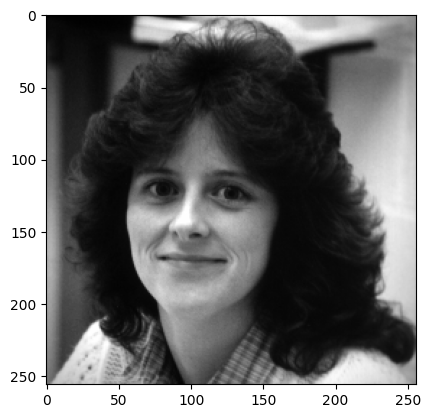

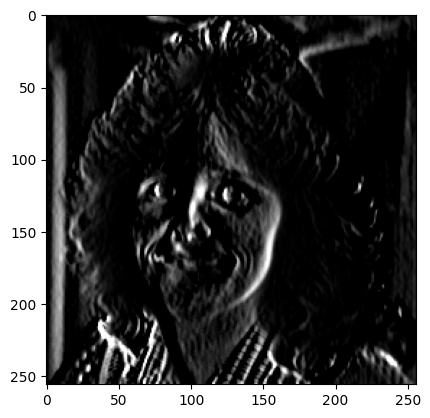

In [21]:
img = cv.imread('images/woman_darkhair.png', cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (0, 0), fx=0.5, fy=0.5)
plt.imshow(img, cmap='gray')
plt.show()

kernel = np.array([[1, 1, -1, -1],
                   [1, 1, -1, -1],
                   [1, 1, -1, -1],
                   [1, 1, -1, -1]])
img_out = cv.filter2D(img, -1, kernel)
plt.imshow(img_out, cmap='gray')

> ### Assignment 6: Mouth Detection
>
> Let's also find the mouth. Guided by the patterns you see in the pixel intensities, try to construct a kernel which will highlight the mouth in the image.

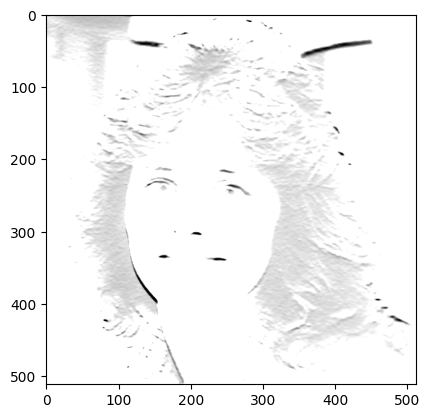

In [24]:
img = cv.imread('images/woman_darkhair.png', cv.IMREAD_GRAYSCALE)
cv.imwrite('images/woman_darkhair.png', img)

kernel = np.array([[-1, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1],
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1]])
img_out = cv.filter2D(img, -1, kernel)
plt.imshow(img_out, cmap='gray')

## Convolution Theorem

The **convolution theorem** states:

> *Convolution in the spatial domain corresponds to element-wise multiplication in the frequency domain.*

Mathematically:

\begin{equation}
f * g = \mathcal{F}^{-1} \left( \mathcal{F}(f) \cdot \mathcal{F}(g) \right)
\end{equation}

Where:
- $ f $ is the input image (spatial domain),
- $ g $ is the kernel (spatial domain),
- $ \mathcal{F} $ denotes the Fourier Transform,
- $ * $ denotes convolution.

> ### Assignment 7: Convolution Theorem
>
> 1. **Load an Image and Kernel**:
>    - Use a grayscale image and a small convolution kernel (e.g., Gaussian blur or edge detection kernel).
>
> 2. **Perform Convolution in Two Ways**:
>    - **Spatial Domain**: Convolve the image with the kernel using the `convolve_py` function you implemented earlier.
>    - **Frequency Domain**:
>      - Compute the Fourier Transform of both the image and the kernel.
>      - Multiply the transforms element-wise.
>      - Perform the **inverse Fourier Transform** to return to the spatial domain.
>
> 3. **Compare Results**:
>    - Visualize the results of both approaches.
>    - Analyze and explain why the outputs are the same.
>
> **Hints**:
>
> You will need to **pad the kernel** to match the size of the image before applying the Fourier Transform. This means you will create a new matrix the same size as the image, where:
>
> The original kernel is placed in the top-left corner of the matrix. The rest of the matrix is filled with zeros.
>
> Since the kernel needs to be centered during convolution, you must roll (shift) the padded kernel so that its center aligns with the center of the image. This ensures proper alignment in the frequency domain.
>
> Use `numpy.fft.fft2` for the Fourier Transform and `numpy.fft.ifft2` for the inverse.

Done! Don't forget to save the notebook on GitHub.